In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:20]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape,end=',')
    dfs.append(a)
print()
data1 = pd.concat(dfs)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
data_all = deepcopy(data1)

data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

In [ ]:
import pickle
pickle.dump(data_all,open('../data_users/merged_data.p','wb'),protocol=4)

In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
data_all = pickle.load(open('../data_users/merged_data.p','rb'))

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
def get_data1(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>20:
        return [],[],[],[],[],[]
    ecg_rr[np.isnan(ecg_rr)] = 0
    m = np.percentile(ecg_rr[ecg_rr>0],80)
    s = np.percentile(ecg_rr[ecg_rr>0],20)
    if len(ecg_rr)<60:
        return [],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<50:
            continue
        index = np.isnan(ppg_rr)
        ppg_qual[index] = -1
        tmp = a[:,np.array([-2,-3,-4,-5,-6,-7,-8,-9,1])].reshape(60,9)
        tmp[np.isnan(tmp[:,0]),0] = np.nanmean(tmp[~np.isnan(tmp[:,0]),0])
        tmp[tmp[:,0]==0,0] = np.mean(tmp[tmp[:,0]>0,0])
        tmp[np.isnan(tmp)] = 0
        y.append(tmp[:,0].reshape(1,60,1))
        X.append(tmp.reshape(1,60,9))
        means.append(m)
        stds.append(s)
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
    return X,y,ecg,means,stds,quals

unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    return df.reshape(-1,60,11)
def get_all_data(data_user):
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        return []
    df_col = [get_data(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    df_user = np.concatenate(df_col)
    df_col = [get_data1(a) for a in df_user if len(a[~np.isnan(a[:,-1]),-1])>20]
    return df_col
# for user in unique_users:
#     data_user = data_all[data_all.user.isin([user])]
all_X = Parallel(n_jobs=20,verbose=3)(delayed(get_all_data)(data_all[data_all.user.isin([user])]) for user in unique_users)

In [ ]:
X,y,ecg,means,stds,quals = [],[],[],[],[],[]
for i,b in enumerate(all_X):
    if len(b)==0:
        continue
    for a in b:
        X.extend(a[0])
        y.extend(a[1])
        ecg.extend(a[2])
        means.extend(a[3])
        stds.extend(a[4])
        quals.extend(a[5])

In [ ]:
import pickle
pickle.dump([X,y,ecg,means,stds,quals],open('../data_users/processed_data.p','wb'),protocol=4)

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
X,y,ecg,means,stds,quals = pickle.load(open('../data_users/processed_data.p','rb'))

In [2]:
X,y,ecg,means,stds,quals = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals)

In [4]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute,Conv1D,Dropout,BatchNormalization
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tfp
X_train, X_test, y_train, y_test,ecg_train, \
ecg_test,means_train,means_test,stds_train,stds_test, \
quals_train,quals_test= train_test_split(
    X[:,:,np.array([0,4])], y,ecg,means,stds,quals, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val,means_train,means_val,stds_train,stds_val = train_test_split(
    X_train, y_train,means_train,stds_train, test_size=0.2, random_state=42)
print(X_train.shape,y_test.shape,y_val.shape,means_val.shape,stds_val.shape)

(7655, 60, 2) (4714, 60) (1914, 60) (1914, 1) (1914, 1)


In [8]:
def output_of_lambda(input_shape):
    return (input_shape[0], 1)

def mean(x):
    return tfp.stats.percentile(x,80,axis=1)

def output_of_lambda1(input_shape):
    return (input_shape[0], 1)

def mean1(x):
    return tfp.stats.percentile(x,20,axis=1)


timesteps = 60
input_dim = 2
latent_dim = 20
output_dim = 1
n = 1
input_shape = (timesteps,input_dim)
act = 'relu'
inputs = Input(shape=input_shape)
encoded = Conv1D(200,5,input_shape=input_shape,activation=act,kernel_initializer='normal',padding='same')(inputs)
encoded = BatchNormalization()(encoded)
encoded = Dropout(.2)(encoded)
att = Dense(1,activation='relu')(encoded)
att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(200)(att)
att = Permute((2,1))(att)
encoded = multiply([att, encoded])

encoded = Conv1D(100,5,activation=act,kernel_initializer='normal',padding='same')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(.2)(encoded)
att = Dense(1,activation='relu')(encoded)
att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(100)(att)
att = Permute((2,1))(att)
encoded = multiply([att, encoded])

encoded = Flatten()(encoded)
encoded = Dense(10,activation='relu',name='sequence1')(encoded)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
decoded = Lambda(mean, output_shape=output_of_lambda,name='mean')(encoded)
decoded1 = Lambda(mean1, output_shape=output_of_lambda1,name='std')(encoded)
sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded,decoded,decoded1])
losses = {
    "std":"logcosh",
    "mean": "logcosh",
    "sequence": "logcosh"
}
lossWeights = {"mean": 1, "sequence": 1,"std":1}
# initialize the optimizer and compile the model

sequence_autoencoder.compile(optimizer='adam',loss=losses, loss_weights=lossWeights)

sequence_autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 60, 2)        0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 60, 200)      2200        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 60, 200)      800         conv1d_2[0][0]                   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 60, 200)      0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [9]:
filepath = '../models/base_CNN.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, [y_train,means_train,stds_train],
                epochs=300,
                batch_size=1000,
                shuffle=True,
                validation_data=(X_val,[y_val,means_val,stds_val]),callbacks=callbacks_list)

Train on 7655 samples, validate on 1914 samples
Epoch 1/300
7655/7655 [==============================] - 9s 1ms/step - loss: 1534.4286 - sequence_loss: 768.7741 - mean_loss: 726.6345 - std_loss: 39.1073 - val_loss: 1531.7875 - val_sequence_loss: 768.3173 - val_mean_loss: 724.5167 - val_std_loss: 38.9631

Epoch 00001: val_loss improved from inf to 1531.78750, saving model to ../models/base_CNN.hdf5
Epoch 2/300
7655/7655 [==============================] - 2s 320us/step - loss: 1531.6869 - sequence_loss: 768.0054 - mean_loss: 724.5833 - std_loss: 39.1257 - val_loss: 1527.8965 - val_sequence_loss: 767.2219 - val_mean_loss: 721.7206 - val_std_loss: 38.9631

Epoch 00002: val_loss improved from 1531.78750 to 1527.89649, saving model to ../models/base_CNN.hdf5
Epoch 3/300
7655/7655 [==============================] - 2s 320us/step - loss: 1527.7159 - sequence_loss: 766.6862 - mean_loss: 721.9311 - std_loss: 39.0948 - val_loss: 1522.5905 - val_sequence_loss: 765.4941 - val_mean_loss: 718.1419 - 


Epoch 00023: val_loss improved from 593.68259 to 494.69339, saving model to ../models/base_CNN.hdf5
Epoch 24/300
7655/7655 [==============================] - 2s 321us/step - loss: 481.1495 - sequence_loss: 356.0751 - mean_loss: 85.3827 - std_loss: 39.1156 - val_loss: 447.5202 - val_sequence_loss: 341.5770 - val_mean_loss: 66.9597 - val_std_loss: 38.9631

Epoch 00024: val_loss improved from 494.69339 to 447.52022, saving model to ../models/base_CNN.hdf5
Epoch 25/300
7655/7655 [==============================] - 2s 320us/step - loss: 456.0698 - sequence_loss: 340.5560 - mean_loss: 76.2904 - std_loss: 39.0780 - val_loss: 439.1352 - val_sequence_loss: 330.8549 - val_mean_loss: 69.2741 - val_std_loss: 38.9631

Epoch 00025: val_loss improved from 447.52022 to 439.13523, saving model to ../models/base_CNN.hdf5
Epoch 26/300
7655/7655 [==============================] - 2s 321us/step - loss: 449.7375 - sequence_loss: 332.7939 - mean_loss: 77.6707 - std_loss: 39.0627 - val_loss: 433.1962 - val_se

7655/7655 [==============================] - 2s 323us/step - loss: 423.4240 - sequence_loss: 309.4143 - mean_loss: 74.8318 - std_loss: 39.1120 - val_loss: 438.1816 - val_sequence_loss: 315.6577 - val_mean_loss: 83.5598 - val_std_loss: 38.9631

Epoch 00049: val_loss did not improve from 426.52455
Epoch 50/300
7655/7655 [==============================] - 2s 321us/step - loss: 423.3227 - sequence_loss: 309.2501 - mean_loss: 74.5842 - std_loss: 39.0801 - val_loss: 436.8682 - val_sequence_loss: 315.1515 - val_mean_loss: 82.7523 - val_std_loss: 38.9631

Epoch 00050: val_loss did not improve from 426.52455
Epoch 51/300
7655/7655 [==============================] - 2s 323us/step - loss: 423.4110 - sequence_loss: 309.1666 - mean_loss: 75.0731 - std_loss: 39.0904 - val_loss: 441.7267 - val_sequence_loss: 316.7670 - val_mean_loss: 86.0045 - val_std_loss: 38.9631

Epoch 00051: val_loss did not improve from 426.52455
Epoch 52/300
7655/7655 [==============================] - 2s 322us/step - loss: 423

In [ ]:
from keras.models import load_model
import tensorflow_probability as tfp
sequence_autoencoder = load_model(filepath)

In [10]:
y_pred1 = sequence_autoencoder.predict(X_test)
y_pred = y_pred1[0]
mean_pred = y_pred1[1]
stds_pred = y_pred1[2]

In [11]:
y_pred1[0].shape,y_pred1[1].shape,y_pred1[2].shape

((4714, 60), (4714,), (4714,))

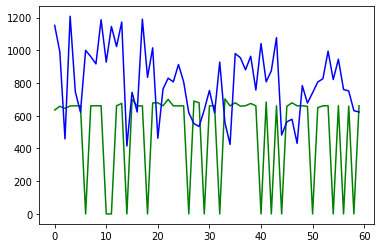

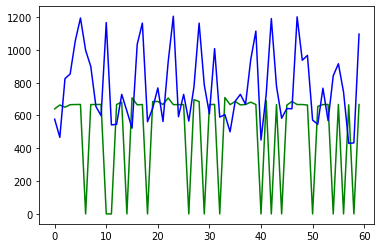

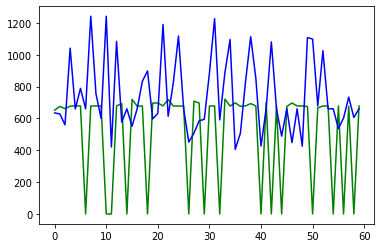

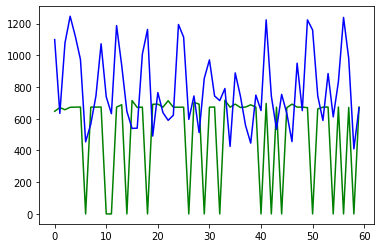

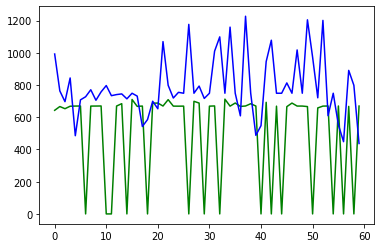

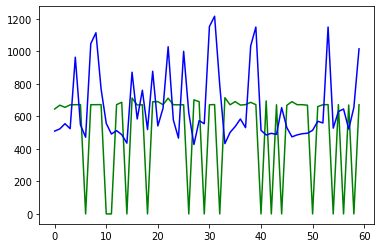

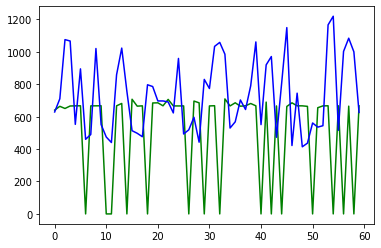

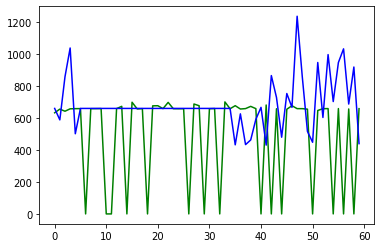

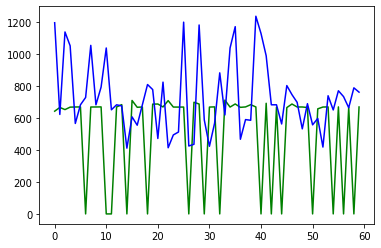

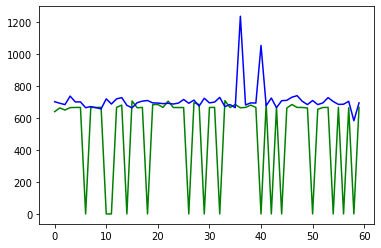

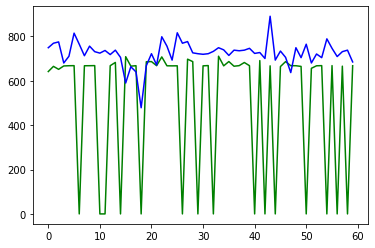

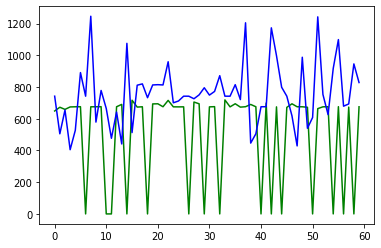

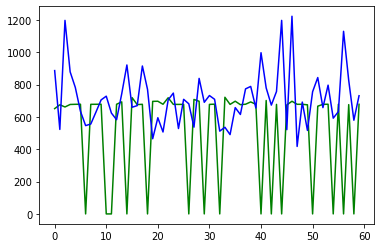

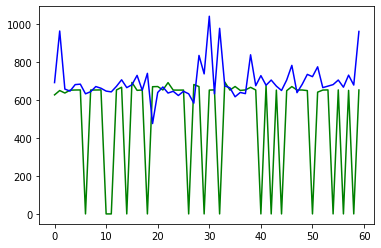

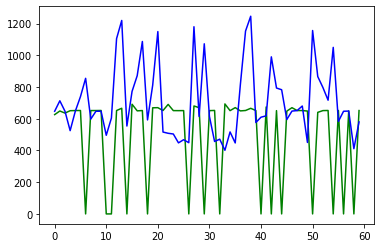

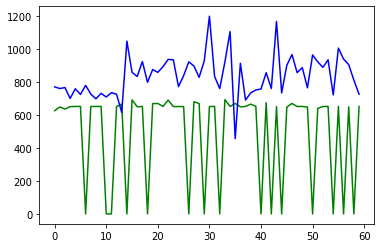

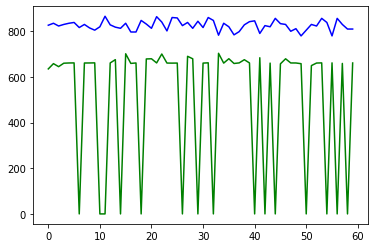

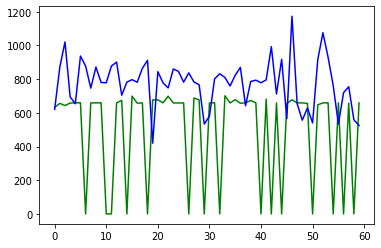

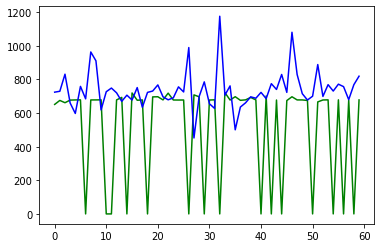

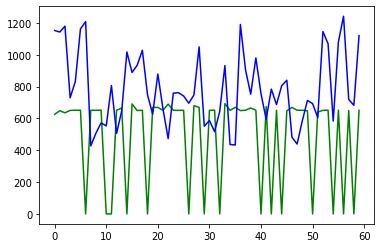

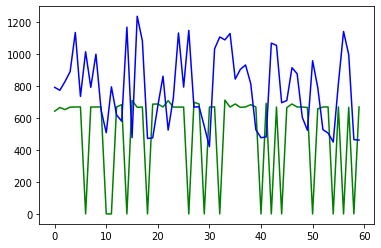

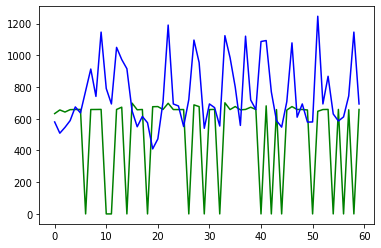

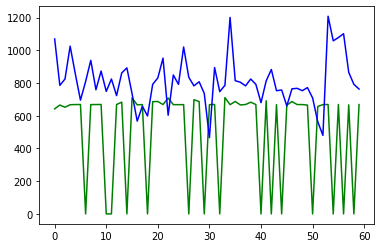

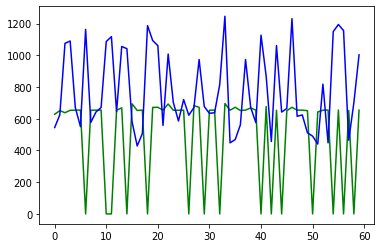

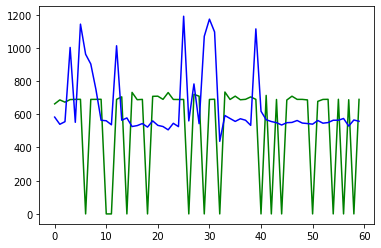

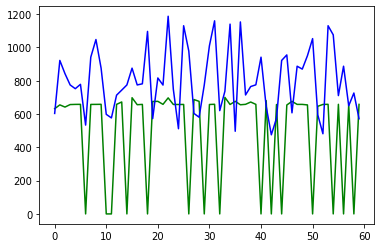

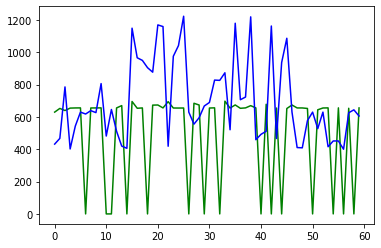

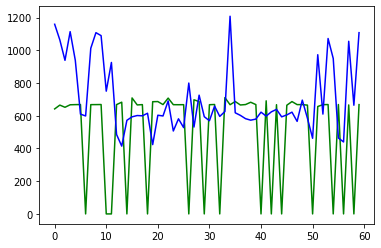

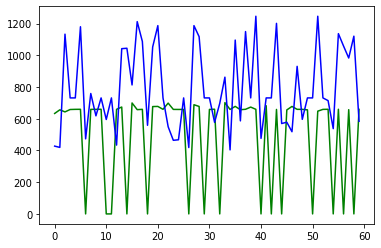

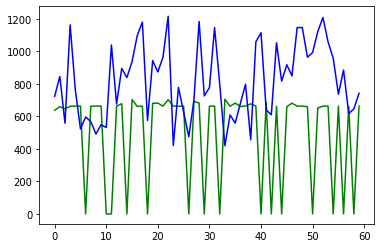

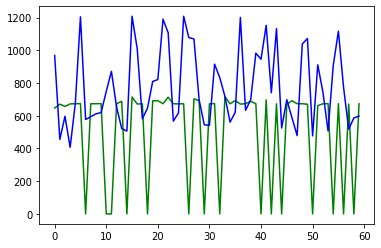

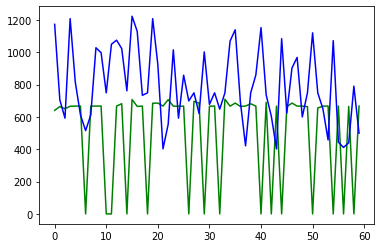

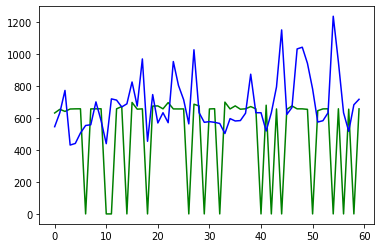

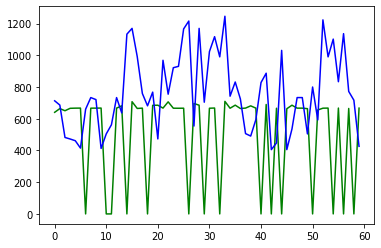

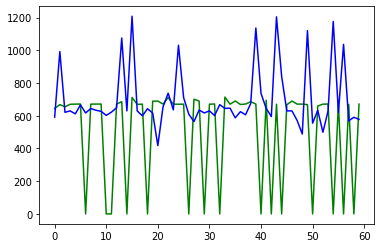

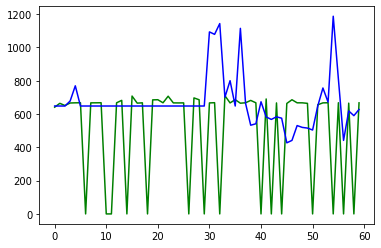

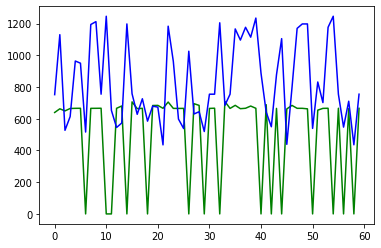

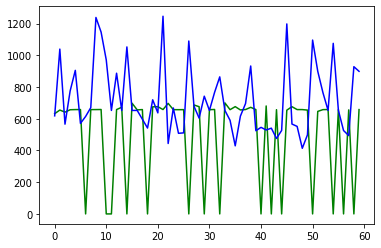

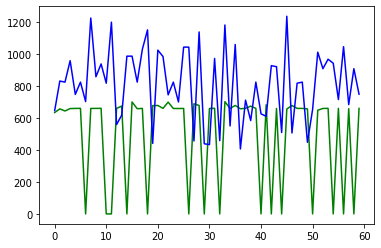

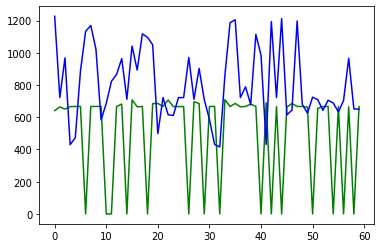

In [12]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[::-1][200:240]):
#     if np.sum(a)>0:
    plt.figure()
    plt.plot(a,'g')
#         plt.plot(X[i,:,:],'r')
    plt.plot(y_test[i],'b')
#     plt.plot(ecg_test[i],'r')
    plt.show()

In [13]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [14]:
X = X[X[:,0]>-1]
X = X[X[:,2]>0]
X = X[X[:,3]>0]


(array([87494., 32077., 18163., 14610., 13115., 11999., 11601., 11898.,
        13741., 42297.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

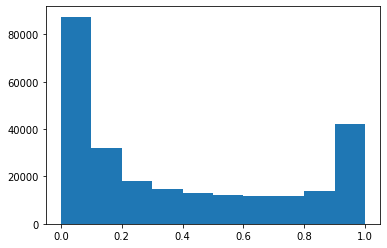

In [15]:
plt.hist(X[:,0])

(52937, 4) 0.0
(34557, 4) 0.05
(19529, 4) 0.1
(12548, 4) 0.15000000000000002
(9828, 4) 0.2
(8229, 4) 0.25
(7528, 4) 0.30000000000000004
(7082, 4) 0.35000000000000003
(6741, 4) 0.4
(6374, 4) 0.45
(6145, 4) 0.5
(5854, 4) 0.55
(5755, 4) 0.6000000000000001
(5938, 4) 0.65
(5853, 4) 0.7000000000000001
(6144, 4) 0.75
(6689, 4) 0.8
(7266, 4) 0.8500000000000001
(9239, 4) 0.9
(22103, 4) 0.9500000000000001
20 20


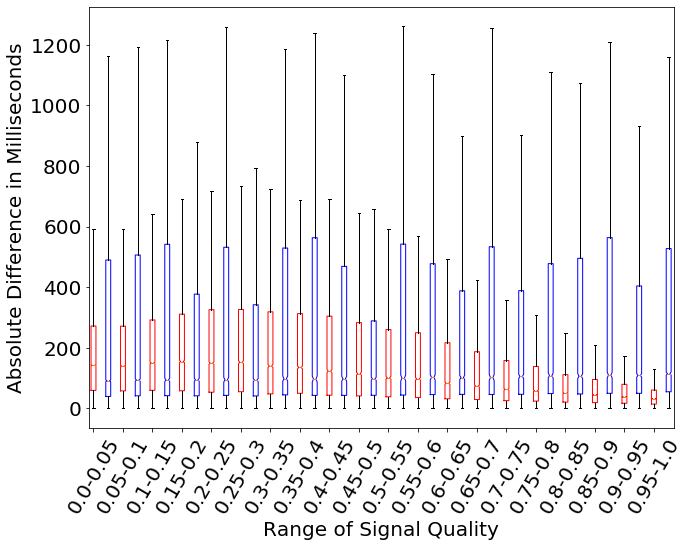

In [16]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [ ]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'rmssd'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(get_time_domain_features(y_pred_min)[s])
    y.append(get_time_domain_features(ecg_min)[s])
    z.append(get_time_domain_features(y_test_min)[s])
    q.append(np.median(qual_min))
    if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
    elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [ ]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape

In [ ]:
plt.hist(quals_test.reshape(-1))

In [ ]:
!pip install --user tensorflow-probability